In [1]:
import pandas as pd
import numpy as np
import os
import random
from copy import deepcopy
import math
from itertools import product
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# user_df = pd.read_csv('./data/user_spec.csv')
loan_df = pd.read_csv('./data/loan_result.csv')
# log_df = pd.read_csv('./data/log_data.csv' )

In [3]:
loan_df.shape

(13527363, 7)

In [4]:
loan_df['is_applied'].dropna(axis=0).index

Int64Index([   13284,    13285,    13286,    13287,    13288,    13289,
               13290,    13291,    13292,    13293,
            ...
            13519629, 13519630, 13519631, 13519632, 13519633, 13519634,
            13519635, 13519636, 13519637, 13519638],
           dtype='int64', length=10270124)

In [5]:
loan_df = loan_df.loc[loan_df['is_applied'].dropna(axis=0).index]
loan_df.drop(['loanapply_insert_time'], axis=1, inplace=True)

In [6]:
random_list = [ random.randint(1,1000) for i in range(2)]
random_list

[317, 606]

In [7]:
for mypath in ['./mydata','./model','./visual','./perf']:
    if not os.path.isdir(mypath):
        os.mkdir(mypath)

In [9]:
acc_list=[]
f1_list=[]
confusion_list=[]

tmp = loan_df.fillna(0)
for i, state in enumerate(random_list,1):
    data_set = pd.concat([tmp[tmp['is_applied']==0].sample(560449, random_state=state), tmp[tmp['is_applied']==1]])
    
    X,y= data_set.loc[:, data_set.columns !='is_applied'] ,data_set['is_applied']
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=state)
    model = RandomForestClassifier(random_state=state)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test,y_pred))
    confusion_list.append(confusion_matrix(y_test,y_pred))
    
    with open(f'./mydata/zero_fill_index_{i}.txt','w') as f:
        f.write('\n'.join(map(str,data_set.index)))
    saved_model = pickle.dumps(model)
    
    joblib.dump(model,f'./model/zero_fill_model_{i}.pkl')
    print(i,'done')

1 done
2 done


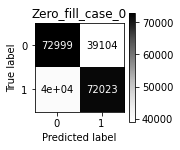

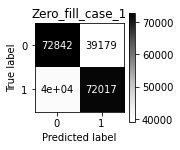

In [10]:
for i, cm in enumerate(confusion_list):
    d=ConfusionMatrixDisplay(cm,display_labels=[0,1])
    fig,ax=plt.subplots(figsize=(2,2))
    d.plot(cmap='Greys',ax=ax)
    plt.title(f'Zero_fill_case_{i}')
    plt.savefig(f'./visual/zero_fill_{i}.png')

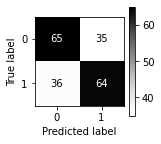

In [11]:
new_cm = np.array([cm[0]/sum(cm[0])*100, cm[1]/sum(cm[1])*100])
d=ConfusionMatrixDisplay(new_cm,display_labels=[0,1])
fig,ax=plt.subplots(figsize=(2,2))
d.plot(cmap='Greys',ax=ax)


##

In [12]:
null_feature = ['loan_limit','loan_rate']
options = [0, 'min', 'max', 'mean', 'median']

In [13]:
my_options = product(options, repeat=len(null_feature))
random_list = [ random.randint(1,1000) for i in range(len(list(my_options)))]
print(*random_list)

223 43 350 649 917 503 609 179 723 292 810 385 185 915 811 144 218 22 435 521 819 661 994 317 653


In [16]:
model_list = []
acc_list = []
f1_list = []
confusion_list = []
for i, option_group in enumerate(product(options, repeat=len(null_feature))):
    
    tmp = deepcopy(loan_df)
    data_set = pd.concat([tmp[tmp['is_applied']==0].sample(100_000, random_state=random_list[i]), tmp[tmp['is_applied']==1].sample(100_000, random_state=random_list[i])])
    for column_name, option in zip(null_feature, list(product(options, repeat=len(null_feature)))[5]):
        if option == 0:
            data_set[column_name].fillna(0, inplace=True)
        else:
            eval(f'data_set["{column_name}"].fillna(data_set["{column_name}"].{option}(), inplace=True)')

    X,y= data_set.loc[:, data_set.columns !='is_applied'] ,data_set['is_applied']
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=random_list[i])
    model = RandomForestClassifier(random_state=random_list[i])
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    model_list.append(model)
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test,y_pred))
    confusion_list.append(confusion_matrix(y_test,y_pred))
    
    with open(f'./mydata/{option_group[0]}_{option_group[1]}.txt','w') as f:
        f.write('\n'.join(map(str,data_set.index)))
    saved_model = pickle.dumps(model)
    joblib.dump(model,f'./model/{option_group[0]}_{option_group[1]}.pkl')
    print(i, option_group, 'done')

0 (0, 0) done
1 (0, 'min') done
2 (0, 'max') done
3 (0, 'mean') done
4 (0, 'median') done
5 ('min', 0) done
6 ('min', 'min') done
7 ('min', 'max') done
8 ('min', 'mean') done
9 ('min', 'median') done
10 ('max', 0) done
11 ('max', 'min') done
12 ('max', 'max') done
13 ('max', 'mean') done
14 ('max', 'median') done
15 ('mean', 0) done
16 ('mean', 'min') done
17 ('mean', 'max') done
18 ('mean', 'mean') done
19 ('mean', 'median') done
20 ('median', 0) done
21 ('median', 'min') done
22 ('median', 'max') done
23 ('median', 'mean') done
24 ('median', 'median') done


In [18]:
print(*zip(acc_list,f1_list), sep='\n')

(0.65555, 0.6529471032745592)
(0.65345, 0.6507960499798469)
(0.65365, 0.6518745602573123)
(0.6529, 0.6526394796097071)
(0.649275, 0.6500536306717553)
(0.65485, 0.6544353223868643)
(0.657175, 0.654940741299917)
(0.65555, 0.6551188986232792)
(0.65175, 0.6504566897520827)
(0.652, 0.6506199487977511)
(0.656175, 0.6546641556811049)
(0.6566, 0.655272800281082)
(0.651025, 0.6473842423017658)
(0.654575, 0.6533878533978877)
(0.6543, 0.6524929634097306)
(0.648275, 0.6481078512293339)
(0.65565, 0.6549944895301072)
(0.6475, 0.647164806566238)
(0.65515, 0.6518952203098975)
(0.650125, 0.6507100606484139)
(0.654925, 0.6514481957526325)
(0.650775, 0.6490112816904947)
(0.655725, 0.6528348501273099)
(0.655625, 0.6544761331426995)
(0.653875, 0.6509517206605321)


In [24]:
print(*confusion_list, sep=',\n')

[[13261  6702]
 [ 7076 12961]],
[[13221  6817]
 [ 7045 12917]],
[[13175  6781]
 [ 7073 12971]],
[[13073  6648]
 [ 7236 13043]],
[[12941  6983]
 [ 7046 13030]],
[[13121  6793]
 [ 7013 13073]],
[[13273  6764]
 [ 6949 13014]],
[[13136  6634]
 [ 7144 13086]],
[[13109  6961]
 [ 6969 12961]],
[[13119  6859]
 [ 7061 12961]],
[[13211  6818]
 [ 6935 13036]],
[[13209  6796]
 [ 6940 13055]],
[[13227  6831]
 [ 7128 12814]],
[[13160  6891]
 [ 6926 13023]],
[[13190  6771]
 [ 7057 12982]],
[[12975  6997]
 [ 7072 12956]],
[[13151  6769]
 [ 7005 13075]],
[[12969  6994]
 [ 7106 12931]],
[[13290  6758]
 [ 7036 12916]],
[[12969  6840]
 [ 7155 13036]],
[[13298  6668]
 [ 7135 12899]],
[[13116  6966]
 [ 7003 12915]],
[[13281  6764]
 [ 7007 12948]],
[[13179  6830]
 [ 6945 13046]],
[[13245  6853]
 [ 6992 12910]]


## get dummies

In [19]:
null_feature = ['loan_limit','loan_rate']
options = [0, 'min', 'max', 'mean', 'median']

In [20]:
my_options = product(options, repeat=len(null_feature))
random_list = [ random.randint(1,1000) for i in range(len(list(my_options)))]
print(*random_list)

875 950 947 158 548 989 714 906 556 973 166 755 922 172 937 546 280 173 641 188 330 655 54 939 74


In [25]:
model_list = []
acc_list = []
f1_list = []
confusion_list = []
for i, option_group in enumerate(product(options, repeat=len(null_feature))):
    
    tmp = deepcopy(loan_df)
    
    data_set = pd.concat([tmp[tmp['is_applied']==0].sample(100_000, random_state=random_list[i]), tmp[tmp['is_applied']==1].sample(100_000, random_state=random_list[i])])
    pd.get_dummies(data = data_set, columns=['bank_id'], prefix='bank')
    pd.get_dummies(data = data_set, columns=['product_id'], prefix='product')
    data_set.drop(['bank_id','product_id'], axis=1, inplace=True)
    
    for column_name, option in zip(null_feature, list(product(options, repeat=len(null_feature)))[5]):
        if option == 0:
            data_set[column_name].fillna(0, inplace=True)
        else:
            eval(f'data_set["{column_name}"].fillna(data_set["{column_name}"].{option}(), inplace=True)')

    X,y= data_set.loc[:, data_set.columns !='is_applied'] ,data_set['is_applied']
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=random_list[i])
    model = RandomForestClassifier(random_state=random_list[i])
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    model_list.append(model)
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test,y_pred))
    confusion_list.append(confusion_matrix(y_test,y_pred))
    
    with open(f'./mydata/g{option_group[0]}_{option_group[1]}.txt','w') as f:
        f.write('\n'.join(map(str,data_set.index)))
    saved_model = pickle.dumps(model)
    joblib.dump(model,f'./model/g{option_group[0]}_{option_group[1]}.pkl')
    print(i, option_group, 'done')


0 (0, 0) done
1 (0, 'min') done
2 (0, 'max') done
3 (0, 'mean') done
4 (0, 'median') done
5 ('min', 0) done
6 ('min', 'min') done
7 ('min', 'max') done
8 ('min', 'mean') done
9 ('min', 'median') done
10 ('max', 0) done
11 ('max', 'min') done
12 ('max', 'max') done
13 ('max', 'mean') done
14 ('max', 'median') done
15 ('mean', 0) done
16 ('mean', 'min') done
17 ('mean', 'max') done
18 ('mean', 'mean') done
19 ('mean', 'median') done
20 ('median', 0) done
21 ('median', 'min') done
22 ('median', 'max') done
23 ('median', 'mean') done
24 ('median', 'median') done


In [26]:
print(*zip(acc_list,f1_list), sep='\n')

(0.580175, 0.5742463808533834)
(0.582225, 0.5758521789893144)
(0.580325, 0.5769938263827642)
(0.57565, 0.571493486822175)
(0.579275, 0.576234482411301)
(0.573475, 0.5667927786100602)
(0.579975, 0.5752926009252003)
(0.576125, 0.5686957848948131)
(0.58205, 0.5737813583520293)
(0.5784, 0.5726954847210258)
(0.582825, 0.5776619169345245)
(0.582725, 0.5766606640119715)
(0.580975, 0.5745399162330244)
(0.5817, 0.5748767721937091)
(0.5767, 0.5700137132408959)
(0.577775, 0.5730680755327485)
(0.579825, 0.5755486526757079)
(0.5802, 0.575616659927214)
(0.5838, 0.5794685258159038)
(0.5825, 0.5747173270856677)
(0.58335, 0.5782254390848813)
(0.5754, 0.5695458231954582)
(0.5793, 0.5710425694621464)
(0.581675, 0.5772893772893773)
(0.57865, 0.5752091944752497)
